In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

#1
def fx(x1, x2):
    return -(x2 + 47) * np.sin(np.sqrt(np.abs(x2 + x1/2 + 47))) -x1 * np.sin(np.sqrt(np.abs(x1 - (x2 + 47))))

x = np.linspace(-512, 512, 512)
y = np.linspace(-512, 512, 512)
X1, X2 = np.meshgrid(x, y)

x1_flat = X1.flatten()
x2_flat = X2.flatten()
inputs = np.column_stack((x1_flat, x2_flat))
##input-> (x, y) --> row vector matrix

# Calculate target values
targets = fx(x1_flat, x2_flat)

#2: Add Gaussian Noise
Gnoise = 0.1 * np.random.normal(0, 1, targets.shape)#mean 0, std 0.1 gausian noise
targets_noisy = targets + Gnoise

#3: Standardization
inputs_scaled = (inputs - np.mean(inputs, axis=0)) / np.std(inputs, axis=0)
targets_scaled = (targets_noisy - np.mean(targets_noisy)) / np.std(targets_noisy)

# Convert to PyTorch Tensors
X_tensor = torch.FloatTensor(inputs_scaled)
y_tensor = torch.FloatTensor(targets_scaled).unsqueeze(1)


# --- Step 5: Define the MLP Model ---
class SingleLayerMLP(nn.Module):
    def __init__(self, n_hidden_neurons, Fanin = 2):
        super(SingleLayerMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(Fanin, n_hidden_neurons), # Input layer (2 features) -> Hidden
            nn.ReLU(),                      # Activation
            nn.Linear(n_hidden_neurons, 1)  # Hidden -> Output (1 value)
        )

        # Initialization (He Initialization for ReLU)
        self._init_weights()

    def _init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x)


def train_model(model, train_loader, val_loader, epochs=50, lr=0.001, device='cpu'):

    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # --- Training Phase ---
        model.train()
        batch_losses = []

        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            batch_losses.append(loss.item())

        epoch_train_loss = np.mean(batch_losses)
        train_losses.append(epoch_train_loss)

        model.eval()
        batch_val_losses = []
        with torch.no_grad():
            for X_val, y_val in val_loader:
                X_val, y_val = X_val.to(device), y_val.to(device)

                val_preds = model(X_val)
                val_loss = criterion(val_preds, y_val)
                batch_val_losses.append(val_loss.item())

        epoch_val_loss = np.mean(batch_val_losses)#save history
        val_losses.append(epoch_val_loss)

        if (epoch+1) % 50 == 0:#printing log
            print(f"  Epoch {epoch+1}/{epochs} | Train: {epoch_train_loss:.4f} | Val: {epoch_val_loss:.4f}")

    return model, train_losses, val_losses


In [ ]:
#

# 4: Split Data
X_train, X_temp, y_train, y_temp = train_test_split(X_tensor, y_tensor, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

#5. Example run
BATCH_SIZE = 256
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


print("Starting training...")
model, t_loss, v_loss = train_model(model= SingleLayerMLP(10) , train_loader=train_loader, val_loader=val_loader, epochs=10)

print(f"validation loss : {v_loss[-1]}")

Using device: cuda
Starting training...
validation loss : 0.981086801011841


In [ ]:
# 1. Setup Data and K-Fold
dataset_size = len(X_tensor)
k_folds = 3
epochs = 500
BATCH_SIZE = 256
h_neurons_list = [10, 100, 200, 500]



# Define K-Fold splitters
outer_kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
inner_kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# To store final results of the best model per outer fold
outer_test_results = []

# --- OUTER LOOP (Performance Evaluation) ---
for outer_fold, (train_ids, test_ids) in enumerate(outer_kfold.split(X_tensor)):
    print(f"\n====== Outer Fold {outer_fold+1}/{k_folds} ======")

    # Slice data for this Outer Fold
    X_outer_train, X_test = X_tensor[train_ids], X_tensor[test_ids]
    y_outer_train, y_test = y_tensor[train_ids], y_tensor[test_ids]

    # Store average validation loss for each hyperparameter to pick the best one
    avg_val_loss_per_param = {h: [] for h in h_neurons_list}
    avg_train_loss_per_param = {h: [] for h in h_neurons_list}

    # --- INNER LOOP (Hyperparameter Tuning) ---
    for inner_fold, (inner_train_ids, inner_val_ids) in enumerate(inner_kfold.split(X_outer_train)):
        print(f"   --- Inner Fold {inner_fold+1}/{k_folds} ---")

        # Create Inner DataLoaders
        # Note: We slice from X_outer_train, not the original X_tensor
        train_sub = TensorDataset(X_outer_train[inner_train_ids], y_outer_train[inner_train_ids])
        val_sub = TensorDataset(X_outer_train[inner_val_ids], y_outer_train[inner_val_ids])

        train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

        # Grid Search: Try every neuron count
        for h_neurons in h_neurons_list:
            print(f"   Neurons: {h_neurons}")
            # 2. call revised function
            model = SingleLayerMLP(h_neurons)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device) # <--- Fix: Move model to device

            model, t_loss, v_loss = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,
            epochs=epochs,
            device=device
              )


            print(f"H: {h_neurons} | Train RMSE: {np.sqrt(t_loss[-1]):.4f} | Val RMSE: {np.sqrt(v_loss[-1]):.4f}")
            avg_train_loss_per_param[h_neurons].append(t_loss[-1])
            avg_val_loss_per_param[h_neurons].append(v_loss[-1])

    # --- HYPERPARAMETER SELECTION ---
    # 1. Calculate average validation loss across inner folds for each neuron count
    best_h = None
    min_avg_loss = float('inf')

    for h, losses in avg_val_loss_per_param.items():
        avg_loss = np.mean(losses)
        print(f"   Neurons: {h}, Avg Inner Val Loss: {avg_loss:.4f}")
        if avg_loss < min_avg_loss:
            min_avg_loss = avg_loss
            best_h = h

    print(f"   >> Best Hyperparameter for Outer Fold {outer_fold+1}: {best_h} neurons")

    # --- FINAL EVALUATION (Refitting) ---
    # 2. Retrain on the FULL Outer Train set using the Best Hyperparameter
    # --- FINAL EVALUATION ---
    final_train_set = TensorDataset(X_outer_train, y_outer_train)
    final_test_set = TensorDataset(X_test, y_test)

    final_train_loader = DataLoader(final_train_set, batch_size=BATCH_SIZE, shuffle=True)
    final_test_loader = DataLoader(final_test_set, batch_size=BATCH_SIZE, shuffle=False)

    # Retrain with best H
    # Fix: Create model instance and move to device
    final_model = SingleLayerMLP(best_h).to(device)
    final_model, t_hist, v_hist = train_model(final_model, final_train_loader, final_test_loader, epochs, device=device)

    test_rmse = np.sqrt(v_hist[-1])
    outer_test_results.append({'fold': outer_fold+1, 'best_h': best_h, 'rmse': test_rmse})
    print(f" >> [Table c] Fold {outer_fold+1} Test RMSE: {test_rmse:.4f}")

    if outer_fold == k_folds - 1:
        last_model_1 = final_model
        last_t_hist_1 = t_hist
        last_v_hist_1 = v_hist
        last_model_info_1 = {'h': best_h, 't_hist': t_hist, 'v_hist': v_hist}

    # Train the final model for this outer fold
    # final_model, _, test_loss = train_model(n_neurons=best_h, loaders=...)

    # outer_test_results.append(test_loss)


====== Outer Fold 1/3 ======
   --- Inner Fold 1/3 ---
   Neurons: 10
  Epoch 50/500 | Train: 0.9607 | Val: 0.9705
  Epoch 100/500 | Train: 0.9572 | Val: 0.9666
  Epoch 150/500 | Train: 0.9543 | Val: 0.9633
  Epoch 200/500 | Train: 0.9513 | Val: 0.9612
  Epoch 250/500 | Train: 0.9501 | Val: 0.9602
  Epoch 300/500 | Train: 0.9495 | Val: 0.9591
  Epoch 350/500 | Train: 0.9478 | Val: 0.9586
  Epoch 400/500 | Train: 0.9487 | Val: 0.9578
  Epoch 450/500 | Train: 0.9480 | Val: 0.9579
  Epoch 500/500 | Train: 0.9439 | Val: 0.9548
H: 10 | Train RMSE: 0.9715 | Val RMSE: 0.9771
   Neurons: 100
  Epoch 50/500 | Train: 0.8967 | Val: 0.9084
  Epoch 100/500 | Train: 0.8308 | Val: 0.8394
  Epoch 150/500 | Train: 0.7804 | Val: 0.7901
  Epoch 200/500 | Train: 0.7237 | Val: 0.7256
  Epoch 250/500 | Train: 0.6678 | Val: 0.6737
  Epoch 300/500 | Train: 0.5686 | Val: 0.5687
  Epoch 350/500 | Train: 0.5511 | Val: 0.5561
  Epoch 400/500 | Train: 0.5376 | Val: 0.5402
  Epoch 450/500 | Train: 0.5261 | Val: 0.

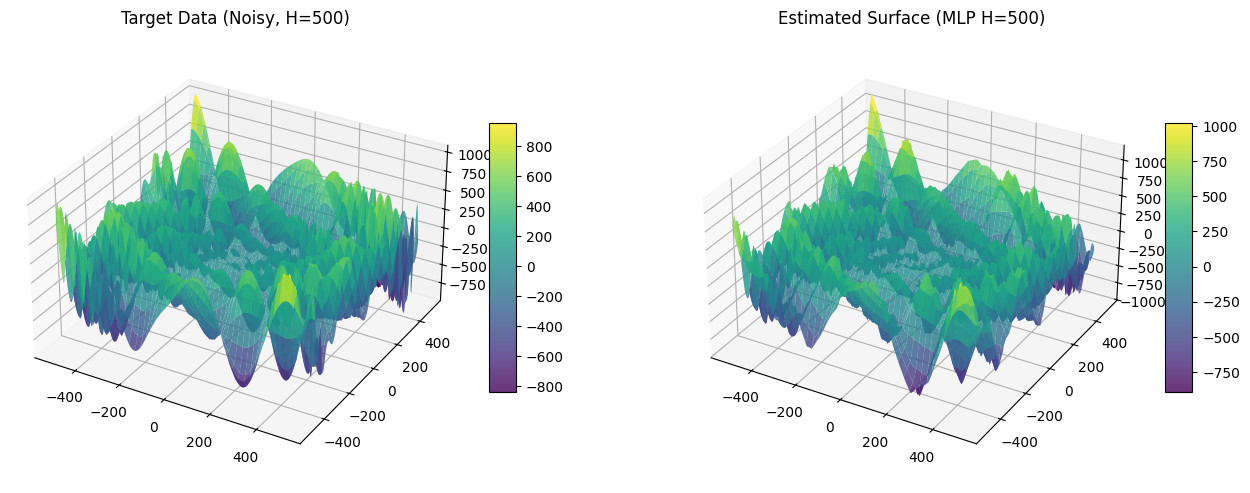

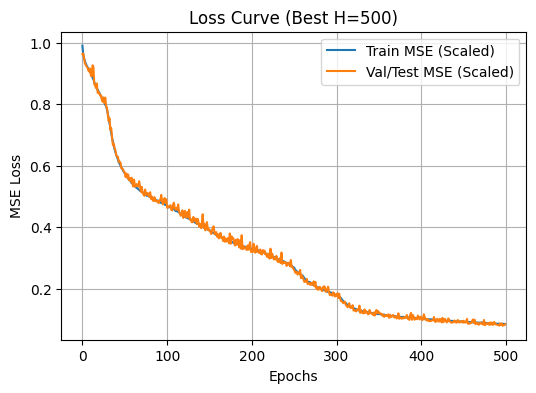

In [ ]:
from re import X
# 1. Surface Plot

fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

trgt_grid = targets_noisy.reshape(X1.shape)


step = 2
surf1 = ax1.plot_surface(X1[::step, ::step], X2[::step, ::step],
                         trgt_grid[::step, ::step],
                         cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_title(f"Target Data (Noisy, H={last_model_info_1['h']})")
try:
    ax1.set_box_aspect((1, 1, 0.6))
except Exception:
    pass

fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)


# --- Estimated Surface ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

X_mean = np.mean(inputs, axis=0)
X_std = np.std(inputs, axis=0)
y_mean = np.mean(targets_noisy)
y_std = np.std(targets_noisy)

X_grid_flat = np.column_stack((X1.flatten(), X2.flatten()))
X_grid_scaled = (X_grid_flat - X_mean) / X_std
X_grid_tensor = torch.FloatTensor(X_grid_scaled).to(device)

with torch.no_grad():
    # model prodiction (transfer from GPU to CPU)
    Y_pred_scaled = last_model_1(X_grid_tensor).cpu().numpy()

# Denormalization
Y_pred = (Y_pred_scaled * y_std) + y_mean
Y_pred = Y_pred.reshape(X1.shape)

# plot prediction surface
surf2 = ax2.plot_surface(X1[::step, ::step], X2[::step, ::step],
                         Y_pred[::step, ::step],
                         cmap='viridis', edgecolor='none', alpha=0.8)
ax2.set_title(f"Estimated Surface (MLP H={last_model_info_1['h']})")
try:
    ax2.set_box_aspect((1, 1, 0.6))
except Exception:
    pass
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.show()

# 2. Loss Plot
plt.figure(figsize=(6, 4))
plt.plot(last_model_info_1['t_hist'], label='Train MSE (Scaled)')
plt.plot(last_model_info_1['v_hist'], label='Val/Test MSE (Scaled)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title(f'Loss Curve (Best H={last_model_info_1["h"]})')
plt.legend()
plt.grid()
plt.show()

# Q7. hand made(FourierFeatureMapper)

In [ ]:
class FourierFeatureMapper:
    def __init__(self, input_dim=2, mapping_size=256, scale_factor=10):

        self.input_dim = input_dim
        self.mapping_size = mapping_size
        self.B = None
        self.scale_factor = scale_factor

    def fit(self, seed=42):
        np.random.seed(seed)
        b_low = np.random.normal(0, 1, size=(self.mapping_size // 4, self.input_dim))
        b_mid = np.random.normal(0, self.scale_factor, size=(self.mapping_size // 2, self.input_dim))
        b_high = np.random.normal(0, self.scale_factor * 10, size=(self.mapping_size // 4, self.input_dim))
        self.B = np.concatenate([b_low, b_mid, b_high], axis=0).T

    def transform(self, x):
        x_proj = (2. * np.pi * x) @ self.B
        x_sin = np.sin(x_proj)
        x_cos = np.cos(x_proj)
        x_aug = np.concatenate([x, x_sin, x_cos], axis=1)

        return x_aug

mapper = FourierFeatureMapper(input_dim=2, mapping_size=128, scale_factor=5)
mapper.fit()
X_aug = mapper.transform(X_tensor)

print(f"original dimension: {X_tensor.shape}")   # (10, 2)
print(f"transformed dimension: {X_aug.shape}") # (10, 2 + 128 + 128) = (10, 258)


/tmp/ipykernel_76424/2164920807.py:35: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_proj = (2. * np.pi * x) @ self.B
/tmp/ipykernel_76424/2164920807.py:39: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_sin = np.sin(x_proj)
/tmp/ipykernel_76424/2164920807.py:40: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x_cos = np.cos(x_proj)


원본 차원: torch.Size([262144, 2])
변환된 차원: (262144, 258)
Using device: cuda


/tmp/ipykernel_76424/2164920807.py:66: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
/tmp/ipykernel_76424/2164920807.py:68: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor = torch.tensor(y_val, dtype=torch.float32)


  Epoch 50/50 | Train: 0.0009 | Val: 0.0010
validation loss : 0.0009592846085093674


In [ ]:


# 1. Setup Data and K-Fold
dataset_size = len(X_aug)
k_folds = 3
epochs = 500
BATCH_SIZE = 256
h_neurons_list = [10, 100, 200, 500]



# Define K-Fold splitters
outer_kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
inner_kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# To store final results of the best model per outer fold
outer_test_results = []

# --- OUTER LOOP (Performance Evaluation) ---
for outer_fold, (train_ids, test_ids) in enumerate(outer_kfold.split(X_aug)):
    print(f"\n====== Outer Fold {outer_fold+1}/{k_folds} ======")

    # Slice data for this Outer Fold
    X_outer_train, X_test = X_aug[train_ids], X_aug[test_ids]
    y_outer_train, y_test = y_tensor[train_ids], y_tensor[test_ids]

    # Store average validation loss for each hyperparameter to pick the best one
    avg_val_loss_per_param = {h: [] for h in h_neurons_list}
    avg_train_loss_per_param = {h: [] for h in h_neurons_list}

    # --- INNER LOOP (Hyperparameter Tuning) ---
    for inner_fold, (inner_train_ids, inner_val_ids) in enumerate(inner_kfold.split(X_outer_train)):
        print(f"   --- Inner Fold {inner_fold+1}/{k_folds} ---")

        # Create Inner DataLoaders
        # Note: We slice from X_outer_train, not the original X_aug
        X_train_tensor2 = torch.tensor(X_outer_train[inner_train_ids], dtype=torch.float32)
        y_train_tensor2 = torch.tensor(y_outer_train[inner_train_ids], dtype=torch.float32)

        X_val_tensor2 = torch.tensor(X_outer_train[inner_val_ids], dtype=torch.float32)
        y_val_tensor2 = torch.tensor(y_outer_train[inner_val_ids], dtype=torch.float32)

        # Fix: Pass the already sliced tensors directly to TensorDataset
        train_sub = TensorDataset(X_train_tensor2, y_train_tensor2)
        val_sub = TensorDataset(X_val_tensor2, y_val_tensor2)

        train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

        # Grid Search: Try every neuron count
        for h_neurons in h_neurons_list:
            print(f"   Neurons: {h_neurons}")
            # 2. call revised function
            model = SingleLayerMLP(h_neurons, Fanin=X_aug.shape[1]) # Pass Fanin for SingleLayerMLP
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device) # <--- Fix: Move model to device

            model, t_loss, v_loss = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,  
            epochs=epochs,
            device=device
              )


            print(f"H: {h_neurons} | Train RMSE: {np.sqrt(t_loss[-1]):.4f} | Val RMSE: {np.sqrt(v_loss[-1]):.4f}")
            avg_train_loss_per_param[h_neurons].append(t_loss[-1])
            avg_val_loss_per_param[h_neurons].append(v_loss[-1])

    # --- HYPERPARAMETER SELECTION ---
    # 1. Calculate average validation loss across inner folds for each neuron count
    best_h = None
    min_avg_loss = float('inf')

    for h, losses in avg_val_loss_per_param.items():
        avg_loss = np.mean(losses)
        print(f"   Neurons: {h}, Avg Inner Val Loss: {avg_loss:.4f}")
        if avg_loss < min_avg_loss:
            min_avg_loss = avg_loss
            best_h = h

    print(f"   >> Best Hyperparameter for Outer Fold {outer_fold+1}: {best_h} neurons")

    # --- FINAL EVALUATION (Refitting) ---
    # 2. Retrain on the FULL Outer Train set using the Best Hyperparameter
    # --- FINAL EVALUATION ---
    # Fix: Convert numpy arrays to torch tensors before creating TensorDataset
    final_train_set = TensorDataset(torch.tensor(X_outer_train, dtype=torch.float32), torch.tensor(y_outer_train, dtype=torch.float32))
    final_test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

    final_train_loader = DataLoader(final_train_set, batch_size=BATCH_SIZE, shuffle=True)
    final_test_loader = DataLoader(final_test_set, batch_size=BATCH_SIZE, shuffle=False)

    # retrain with best H
    # Fix: Create model instance and move to device, and pass Fanin parameter
    final_model = SingleLayerMLP(best_h, Fanin=X_aug.shape[1]).to(device)
    final_model, t_hist, v_hist = train_model(final_model, final_train_loader, final_test_loader, epochs, device=device)

    test_rmse = np.sqrt(v_hist[-1])
    outer_test_results.append({'fold': outer_fold+1, 'best_h': best_h, 'rmse': test_rmse})
    print(f" >> [Table c] Fold {outer_fold+1} Test RMSE: {test_rmse:.4f}")

    if outer_fold == k_folds - 1:
        last_model = final_model
        last_t_hist = t_hist
        last_v_hist = v_hist
        last_model_info = {'h': best_h, 't_hist': t_hist, 'v_hist': v_hist}

    # Train the final model for this outer fold
    # final_model, _, test_loss = train_model(n_neurons=best_h, loaders=...)

    # outer_test_results.append(test_loss)



====== Outer Fold 1/3 ======
   --- Inner Fold 1/3 ---


/tmp/ipykernel_76424/1715934757.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor2 = torch.tensor(y_outer_train[inner_train_ids], dtype=torch.float32) # 분류 문제라면 torch.long
/tmp/ipykernel_76424/1715934757.py:43: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_val_tensor2 = torch.tensor(y_outer_train[inner_val_ids], dtype=torch.float32)


   Neurons: 10
  Epoch 50/500 | Train: 0.0320 | Val: 0.0326
  Epoch 100/500 | Train: 0.0294 | Val: 0.0299
  Epoch 150/500 | Train: 0.0277 | Val: 0.0283
  Epoch 200/500 | Train: 0.0268 | Val: 0.0273
  Epoch 250/500 | Train: 0.0259 | Val: 0.0266
  Epoch 300/500 | Train: 0.0253 | Val: 0.0265
  Epoch 350/500 | Train: 0.0249 | Val: 0.0260
  Epoch 400/500 | Train: 0.0244 | Val: 0.0254
  Epoch 450/500 | Train: 0.0241 | Val: 0.0250
  Epoch 500/500 | Train: 0.0238 | Val: 0.0251
H: 10 | Train RMSE: 0.1542 | Val RMSE: 0.1583
   Neurons: 100
  Epoch 50/500 | Train: 0.0014 | Val: 0.0018
  Epoch 100/500 | Train: 0.0010 | Val: 0.0013
  Epoch 150/500 | Train: 0.0009 | Val: 0.0012
  Epoch 200/500 | Train: 0.0007 | Val: 0.0014
  Epoch 250/500 | Train: 0.0007 | Val: 0.0011
  Epoch 300/500 | Train: 0.0006 | Val: 0.0009
  Epoch 350/500 | Train: 0.0006 | Val: 0.0010
  Epoch 400/500 | Train: 0.0006 | Val: 0.0009
  Epoch 450/500 | Train: 0.0006 | Val: 0.0011
  Epoch 500/500 | Train: 0.0006 | Val: 0.0009
H: 10

/tmp/ipykernel_76424/1715934757.py:91: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_train_set = TensorDataset(torch.tensor(X_outer_train, dtype=torch.float32), torch.tensor(y_outer_train, dtype=torch.float32))
/tmp/ipykernel_76424/1715934757.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  final_test_set = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))


  Epoch 50/500 | Train: 0.0009 | Val: 0.0012
  Epoch 100/500 | Train: 0.0005 | Val: 0.0009
  Epoch 150/500 | Train: 0.0004 | Val: 0.0005
  Epoch 200/500 | Train: 0.0004 | Val: 0.0004
  Epoch 250/500 | Train: 0.0003 | Val: 0.0004
  Epoch 300/500 | Train: 0.0003 | Val: 0.0003
  Epoch 350/500 | Train: 0.0003 | Val: 0.0004
  Epoch 400/500 | Train: 0.0003 | Val: 0.0004
  Epoch 450/500 | Train: 0.0003 | Val: 0.0005
  Epoch 500/500 | Train: 0.0003 | Val: 0.0003
 >> [Table c] Fold 1 Test RMSE: 0.0183

====== Outer Fold 2/3 ======
   --- Inner Fold 1/3 ---
   Neurons: 10
  Epoch 50/500 | Train: 0.0313 | Val: 0.0324
  Epoch 100/500 | Train: 0.0282 | Val: 0.0293
  Epoch 150/500 | Train: 0.0269 | Val: 0.0280
  Epoch 200/500 | Train: 0.0261 | Val: 0.0268
  Epoch 250/500 | Train: 0.0254 | Val: 0.0264
  Epoch 300/500 | Train: 0.0250 | Val: 0.0258
  Epoch 350/500 | Train: 0.0247 | Val: 0.0258
  Epoch 400/500 | Train: 0.0244 | Val: 0.0253
  Epoch 450/500 | Train: 0.0242 | Val: 0.0253
  Epoch 500/500 | 

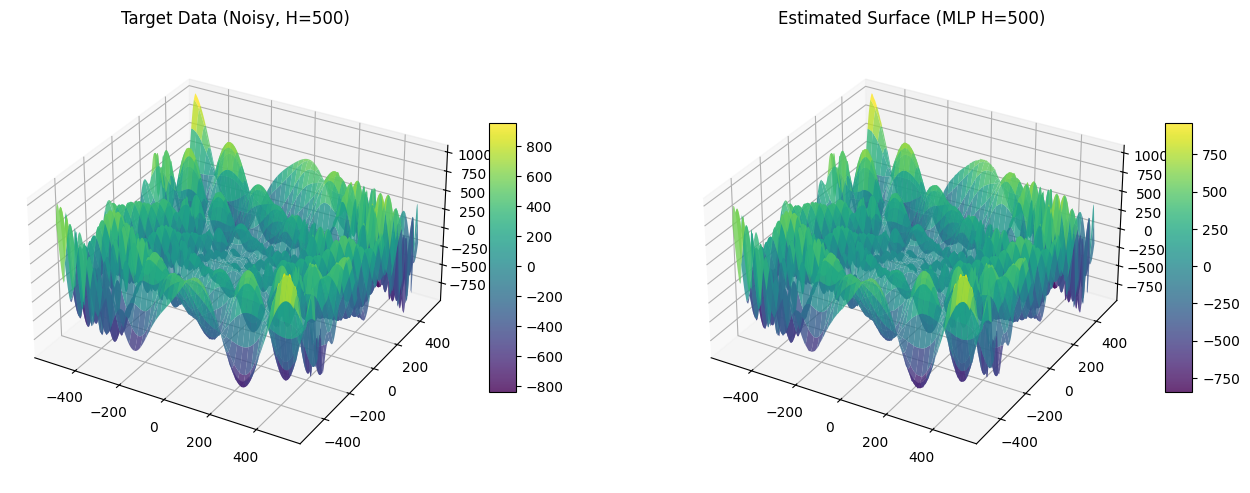

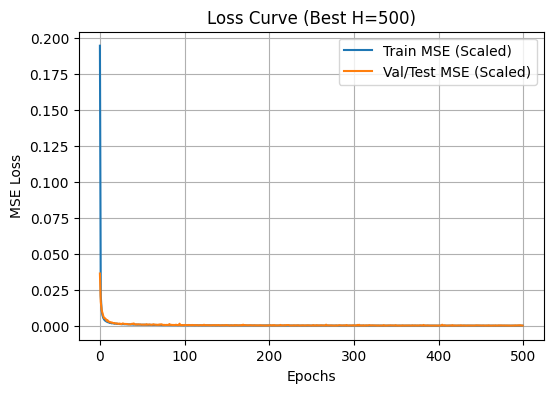

In [ ]:
from re import X
# 1. Surface Plot
fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

trgt_grid = targets_noisy.reshape(X1.shape)

step = 2
surf1 = ax1.plot_surface(X1[::step, ::step], X2[::step, ::step],
                         trgt_grid[::step, ::step],
                         cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_title(f"Target Data (Noisy, H={last_model_info['h']})")
try:
    ax1.set_box_aspect((1, 1, 0.6))
except Exception:
    pass
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)


# --- [Estimated Surface] ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

X_mean = np.mean(inputs, axis=0)
X_std = np.std(inputs, axis=0)
y_mean = np.mean(targets_noisy)
y_std = np.std(targets_noisy)

# input generation& normalization
X_grid_flat = np.column_stack((X1.flatten(), X2.flatten()))
X_grid_scaled = (X_grid_flat - X_mean) / X_std
X_grid_tensor = torch.FloatTensor(X_grid_scaled).to(device)


with torch.no_grad():
    if isinstance(X_tensor, torch.Tensor):
        input_numpy = mapper.transform(X_tensor.cpu().numpy())
    else:
        input_numpy = mapper.transform(X_tensor)

    input_tensor = torch.tensor(input_numpy, dtype=torch.float32).to(device)

    Y_pred_scaled = last_model(input_tensor).cpu().numpy()

# Denormalization
Y_pred = (Y_pred_scaled * y_std) + y_mean
Y_pred = Y_pred.reshape(X1.shape)

# plot prediction surface
surf2 = ax2.plot_surface(X1[::step, ::step], X2[::step, ::step],
                         Y_pred[::step, ::step],
                         cmap='viridis', edgecolor='none', alpha=0.8)
ax2.set_title(f"Estimated Surface (MLP H={last_model_info['h']})")
try:
    ax2.set_box_aspect((1, 1, 0.6))
except Exception:
    pass
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.show()

# 2. Loss Plot
plt.figure(figsize=(6, 4))
plt.plot(last_model_info['t_hist'], label='Train MSE (Scaled)')
plt.plot(last_model_info['v_hist'], label='Val/Test MSE (Scaled)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title(f'Loss Curve (Best H={last_model_info["h"]})')
plt.legend()
plt.grid()
plt.show()

# Q8. ThreeLayerMLP

In [12]:
# --- Step 5: Define three MLP Model ---
class ThreeLayerMLP(nn.Module):
    def __init__(self, n_hidden_neurons, Fanin = 2):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(Fanin, n_hidden_neurons[0]), # Input layer (2 features) -> Hidden
            nn.ReLU(),                      # Activation
            nn.Linear(n_hidden_neurons[0], n_hidden_neurons[1]), # Input layer (2 features) -> Hidden
            nn.ReLU(),                      # Activation
            nn.Linear(n_hidden_neurons[1], n_hidden_neurons[2]), # Input layer (2 features) -> Hidden
            nn.ReLU(),                      # Activation
            nn.Linear(n_hidden_neurons[2], 1)  # Hidden -> Output (1 value)
        )

        # Initialization (He Initialization for ReLU)
        self._init_weights()

    def _init_weights(self):
        for m in self.net:
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        return self.net(x)

#############################just for test . Example run
'''BATCH_SIZE = 256
train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

val_dataset = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)


print("Starting training...")
model, t_loss, v_loss = train_model(model= ThreeLayerMLP((64, 64, 64)) , train_loader=train_loader, val_loader=val_loader, epochs=10)

print(f"validation loss : {v_loss[-1]}")'''

'BATCH_SIZE = 256\ntrain_dataset = TensorDataset(X_train, y_train)\ntrain_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)\n\nval_dataset = TensorDataset(X_val, y_val)\nval_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)\n\n\nprint("Starting training...")\nmodel, t_loss, v_loss = train_model(model= ThreeLayerMLP((64, 64, 64)) , train_loader=train_loader, val_loader=val_loader, epochs=10)\n\nprint(f"validation loss : {v_loss[-1]}")'

In [ ]:


# 1. Setup Data and K-Fold
dataset_size = len(X_tensor)
k_folds = 3
epochs = 500
BATCH_SIZE = 256
h_neurons_list = [(10, 10, 10), (100, 100, 100), (200, 200, 200), (500, 500, 500)]



# Define K-Fold splitters
outer_kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)
inner_kfold = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# To store final results of the best model per outer fold
outer_test_results = []

# --- OUTER LOOP (Performance Evaluation) ---
for outer_fold, (train_ids, test_ids) in enumerate(outer_kfold.split(X_tensor)):
    print(f"\n====== Outer Fold {outer_fold+1}/{k_folds} ======")

    # Slice data for this Outer Fold
    X_outer_train, X_test = X_tensor[train_ids], X_tensor[test_ids]
    y_outer_train, y_test = y_tensor[train_ids], y_tensor[test_ids]

    # Store average validation loss for each hyperparameter to pick the best one
    avg_val_loss_per_param = {h: [] for h in h_neurons_list}
    avg_train_loss_per_param = {h: [] for h in h_neurons_list}

    # --- INNER LOOP (Hyperparameter Tuning) ---
    for inner_fold, (inner_train_ids, inner_val_ids) in enumerate(inner_kfold.split(X_outer_train)):
        print(f"   --- Inner Fold {inner_fold+1}/{k_folds} ---")

        # Create Inner DataLoaders
        # Note: We slice from X_outer_train, not the original X_tensor
        train_sub = TensorDataset(X_outer_train[inner_train_ids], y_outer_train[inner_train_ids])
        val_sub = TensorDataset(X_outer_train[inner_val_ids], y_outer_train[inner_val_ids])

        train_loader = DataLoader(train_sub, batch_size=BATCH_SIZE, shuffle=True)
        val_loader = DataLoader(val_sub, batch_size=BATCH_SIZE, shuffle=False)

        # Grid Search: Try every neuron count
        for h_neurons in h_neurons_list:
            print(f"   Neurons: {h_neurons}")
            # 2. call revised function
            model = ThreeLayerMLP(h_neurons)
            device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
            model.to(device) # <--- Fix: Move model to device

            model, t_loss, v_loss = train_model(
            model=model,
            train_loader=train_loader,
            val_loader=val_loader,  
            epochs=epochs,
            device=device
              )


            print(f"H: {h_neurons} | Train RMSE: {np.sqrt(t_loss[-1]):.4f} | Val RMSE: {np.sqrt(v_loss[-1]):.4f}")
            avg_train_loss_per_param[h_neurons].append(t_loss[-1])
            avg_val_loss_per_param[h_neurons].append(v_loss[-1])

    # --- HYPERPARAMETER SELECTION ---
    # 1. Calculate average validation loss across inner folds for each neuron count
    best_h = None
    min_avg_loss = float('inf')

    for h, losses in avg_val_loss_per_param.items():
        avg_loss = np.mean(losses)
        print(f"   Neurons: {h}, Avg Inner Val Loss: {avg_loss:.4f}")
        if avg_loss < min_avg_loss:
            min_avg_loss = avg_loss
            best_h = h

    print(f"   >> Best Hyperparameter for Outer Fold {outer_fold+1}: {best_h} neurons")

    # --- FINAL EVALUATION (Refitting) ---
    # 2. Retrain on the FULL Outer Train set using the Best Hyperparameter
    # --- FINAL EVALUATION ---
    final_train_set = TensorDataset(X_outer_train, y_outer_train)
    final_test_set = TensorDataset(X_test, y_test)

    final_train_loader = DataLoader(final_train_set, batch_size=BATCH_SIZE, shuffle=True)
    final_test_loader = DataLoader(final_test_set, batch_size=BATCH_SIZE, shuffle=False)

    # Fix: Create model instance and move to device
    final_model = ThreeLayerMLP(best_h).to(device)
    final_model, t_hist, v_hist = train_model(final_model, final_train_loader, final_test_loader, epochs, device=device)

    test_rmse = np.sqrt(v_hist[-1])
    outer_test_results.append({'fold': outer_fold+1, 'best_h': best_h, 'rmse': test_rmse})
    print(f" >> [Table c] Fold {outer_fold+1} Test RMSE: {test_rmse:.4f}")

    if outer_fold == k_folds - 1:
        last_model = final_model
        last_t_hist = t_hist
        last_v_hist = v_hist
        last_model_info = {'h': best_h, 't_hist': t_hist, 'v_hist': v_hist}

    # Train the final model for this outer fold
    # final_model, _, test_loss = train_model(n_neurons=best_h, loaders=...)

    # outer_test_results.append(test_loss)


====== Outer Fold 1/3 ======
   --- Inner Fold 1/3 ---
   Neurons: (10, 10, 10)
  Epoch 50/500 | Train: 0.4998 | Val: 0.5031
  Epoch 100/500 | Train: 0.3341 | Val: 0.3320
  Epoch 150/500 | Train: 0.3097 | Val: 0.3087
  Epoch 200/500 | Train: 0.2957 | Val: 0.2996
  Epoch 250/500 | Train: 0.2781 | Val: 0.2785
  Epoch 300/500 | Train: 0.2642 | Val: 0.2637
  Epoch 350/500 | Train: 0.2559 | Val: 0.2529
  Epoch 400/500 | Train: 0.2472 | Val: 0.2537
  Epoch 450/500 | Train: 0.2443 | Val: 0.2414
  Epoch 500/500 | Train: 0.2404 | Val: 0.2405
H: (10, 10, 10) | Train RMSE: 0.4903 | Val RMSE: 0.4904
   Neurons: (100, 100, 100)
  Epoch 50/500 | Train: 0.0270 | Val: 0.0430
  Epoch 100/500 | Train: 0.0082 | Val: 0.0085
  Epoch 150/500 | Train: 0.0053 | Val: 0.0083
  Epoch 200/500 | Train: 0.0035 | Val: 0.0052
  Epoch 250/500 | Train: 0.0040 | Val: 0.0046
  Epoch 300/500 | Train: 0.0029 | Val: 0.0054
  Epoch 350/500 | Train: 0.0026 | Val: 0.0026
  Epoch 400/500 | Train: 0.0024 | Val: 0.0023
  Epoch 4

In [ ]:
final_model = ThreeLayerMLP(best_h).to(device)
final_model, t_hist, v_hist = train_model(final_model, final_train_loader, final_test_loader, epochs, device=device)

test_rmse = np.sqrt(v_hist[-1])
outer_test_results.append({'fold': outer_fold+1, 'best_h': best_h, 'rmse': test_rmse})
print(f" >> [Table c] Fold {outer_fold+1} Test RMSE: {test_rmse:.4f}")

if outer_fold == k_folds - 1:
    last_model = final_model
    last_t_hist = t_hist
    last_v_hist = v_hist
    last_model_info = {'h': best_h, 't_hist': t_hist, 'v_hist': v_hist}

  Epoch 50/500 | Train: 0.0063 | Val: 0.0063
  Epoch 100/500 | Train: 0.0043 | Val: 0.0027
  Epoch 150/500 | Train: 0.0018 | Val: 0.0018
  Epoch 200/500 | Train: 0.0022 | Val: 0.0014
  Epoch 250/500 | Train: 0.0016 | Val: 0.0015
  Epoch 300/500 | Train: 0.0015 | Val: 0.0014
  Epoch 350/500 | Train: 0.0011 | Val: 0.0011
  Epoch 400/500 | Train: 0.0012 | Val: 0.0009
  Epoch 450/500 | Train: 0.0012 | Val: 0.0008
  Epoch 500/500 | Train: 0.0011 | Val: 0.0018
 >> [Table c] Fold 3 Test RMSE: 0.0427


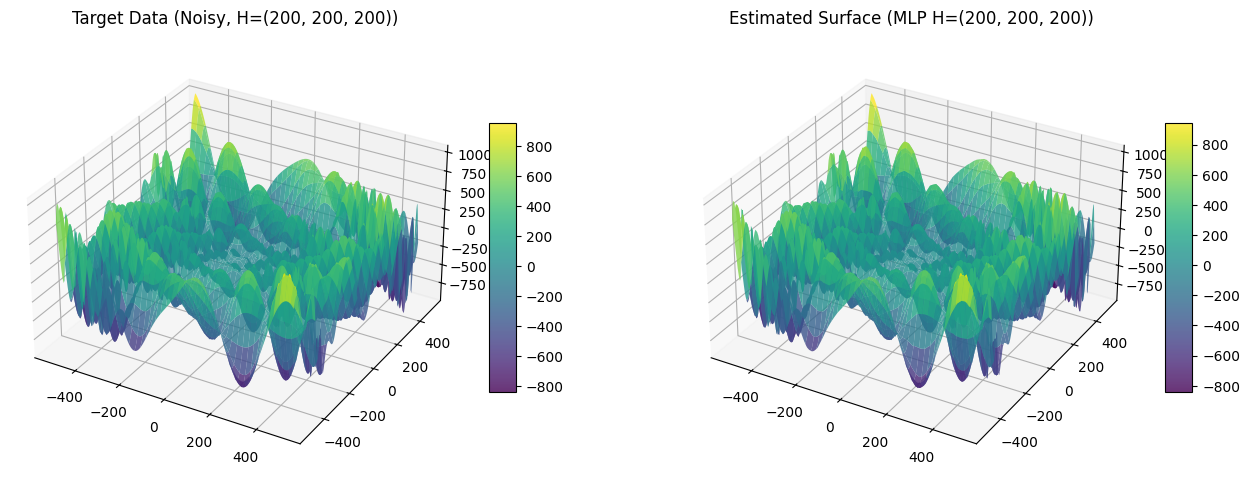

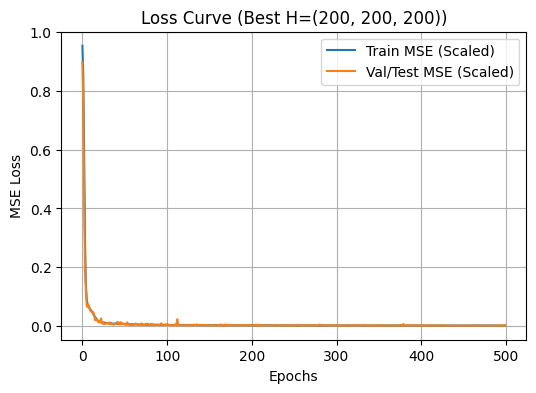

In [ ]:
# 1. Surface Plot
fig = plt.figure(figsize=(16, 7))

ax1 = fig.add_subplot(1, 2, 1, projection='3d')

trgt_grid = targets_noisy.reshape(X1.shape)


step = 2
surf1 = ax1.plot_surface(X1[::step, ::step], X2[::step, ::step],
                         trgt_grid[::step, ::step],
                         cmap='viridis', edgecolor='none', alpha=0.8)
ax1.set_title(f"Target Data (Noisy, H={last_model_info['h']})")
try:
    ax1.set_box_aspect((1, 1, 0.6))
except Exception:
    pass
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)


# --- Estimated Surface ---
ax2 = fig.add_subplot(1, 2, 2, projection='3d')

X_mean = np.mean(inputs, axis=0)
X_std = np.std(inputs, axis=0)
y_mean = np.mean(targets_noisy)
y_std = np.std(targets_noisy)

# input generation and normalization
X_grid_flat = np.column_stack((X1.flatten(), X2.flatten()))
X_grid_scaled = (X_grid_flat - X_mean) / X_std
X_grid_tensor = torch.FloatTensor(X_grid_scaled).to(device)

with torch.no_grad():
    # model prediction
    Y_pred_scaled = model(X_grid_tensor).cpu().numpy()

Y_pred = (Y_pred_scaled * y_std) + y_mean
Y_pred = Y_pred.reshape(X1.shape)

surf2 = ax2.plot_surface(X1[::step, ::step], X2[::step, ::step],
                         Y_pred[::step, ::step],
                         cmap='viridis', edgecolor='none', alpha=0.8)
ax2.set_title(f"Estimated Surface (MLP H={last_model_info['h']})")
try:
    ax2.set_box_aspect((1, 1, 0.6))
except Exception:
    pass
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.show()

# 2. Loss Plot
plt.figure(figsize=(6, 4))
plt.plot(last_model_info['t_hist'], label='Train MSE (Scaled)')
plt.plot(last_model_info['v_hist'], label='Val/Test MSE (Scaled)')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title(f'Loss Curve (Best H={last_model_info["h"]})')
plt.legend()
plt.grid()
plt.show()